In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import json
import logging
import os
from pprint import pprint

from mlff.src.data.preprocessing import split_data
from mlff.src.training import Optimizer, Coach, get_loss_fn, create_train_state
from mlff.src.io.io import create_directory, merge_dicts, bundle_dicts, save_dict
from mlff.src.data import DataTuple, DataSet
from mlff.src.indexing.indices import get_indices
from mlff.src.nn.stacknet import StackNet, get_obs_and_grad_obs_fn, get_obs_and_force_fn
from mlff.src.nn.embed import AtomTypeEmbed, GeometryEmbed
from mlff.src.nn.layer import So3kratesLayer
from mlff.src.nn.observable import Energy
import wandb
logging.basicConfig(level=logging.INFO)

In [2]:
# We start by giving the path to the data we want to train our model on, as well as the path where we want 
# to save the model checkpoints as well as the hyperparamter file. 

data_path = 'example_data/qm7x_250_small.npz'
save_path = '/Users/thorbenfrank/Desktop/qm7x_joint'
ckpt_dir = os.path.join(save_path, 'module')
ckpt_dir = create_directory(ckpt_dir, exists_ok=True)

# next we define the property keys. The keys in the dictionary should not be changed, but the values can be 
# changed arbitrarily such that they match the names in the data file.

prop_keys = {'energy': 'E',
             'force': 'F',
             'atomic_type': 'z',
             'atomic_position': 'R',
             'hirshfeld_volume': None,
             'total_charge': None,
             'total_spin': None,
             'partial_charge': None
             }

E_key = prop_keys['energy']
F_key = prop_keys['force']
z_key = prop_keys['atomic_type']
R_key = prop_keys['atomic_position']

In [3]:
# if we look at the data, we find that there are lots of zeros, which are padded values, since 
# there are structures of different sizes in the data
np.load(data_path)[prop_keys['atomic_type']][np.array([0, 100, 1000])]

array([[8, 6, 6, 6, 6, 6, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0],
       [6, 6, 7, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0],
       [8, 6, 6, 6, 6, 6, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]])

In [4]:
# We now load the data. We assume that the data is given or has been transformed to .npz format.
data = dict(np.load(data_path))
qm7x_250_dataset = DataSet(prop_keys=prop_keys, data=data)
# Next, we split the data, where we define the keys that should be split into training, validation and testing
# data.
r_cut = 5.
d = qm7x_250_dataset.random_split(n_train=500,
                                  n_valid=50,
                                  n_test=None,
                                  training=True,
                                  r_cut=r_cut,
                                  seed=0,
                                  )
qm7x_250_dataset.save_splits_to_file(path=ckpt_dir, filename='qm7x_250_split.json')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:00<00:00, 2618.17it/s]


In [5]:
E = d['train'][E_key]
F = d['train'][F_key]
print('Taking mean and std by hand:\n E_mean={}, F_std={}'.format(E.mean(), F.std()))
E_mean = E[E != 0].mean()
F_scale = F[F != 0].std()
print('Removing padded values:\n E_mean={}, F_std={}'.format(E_mean, F_scale))

Taking mean and std by hand:
 E_mean=-8480.339490048, F_std=1.400136848316319
Removing padded values:
 E_mean=-8480.339490048, F_std=1.6807021287402766


/Users/thorbenfrank/Documents/git/mlff-public/mlff/src/data/preprocessing.py:330: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol = np.linalg.lstsq(X, q)


Hydrogen shift: -16.31968536140837, Carbon shift: -1035.4551868157157


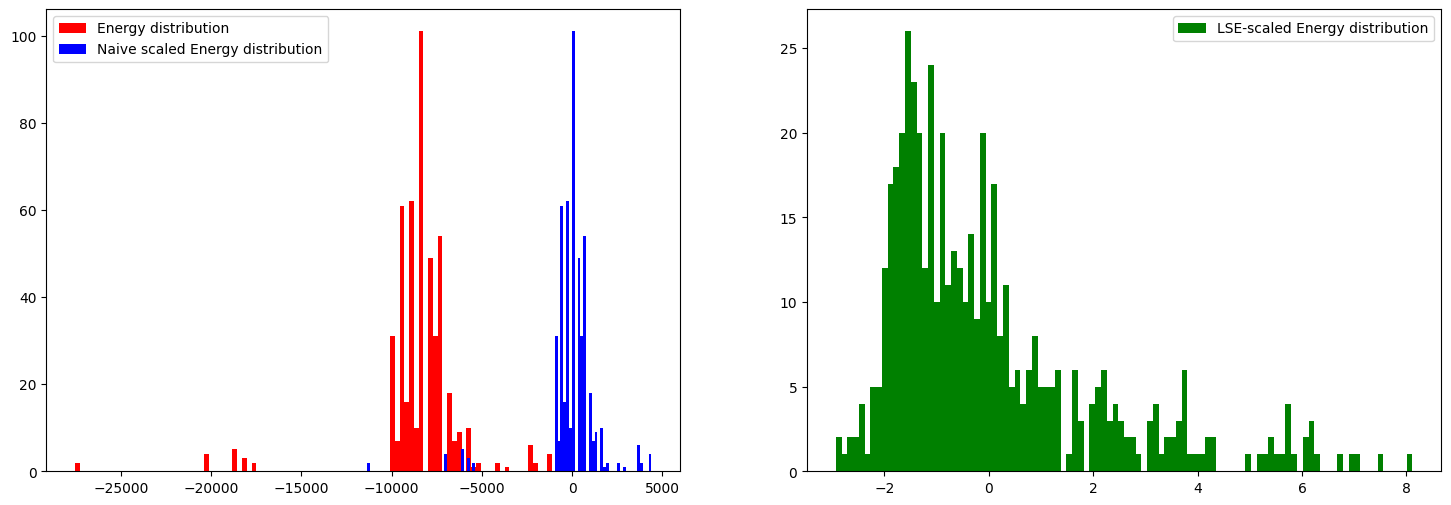

In [6]:
# Having different structures of different sizes and chemical compositions results in a large energy domain that is
# covered in the data. This can be easily seen when looking at the energy distribution. For that reason, scaling by
# the mean energy per atom results in shifted energies that still have large variance, which makes joint
# training problematic. For that reason mlff provides a function which solves the linear system of equations 
# O @ x = E, where O counts the occurences of each atomic type, and E are the per structure energies over the
# training data. Thus, O is of shape (n_data, z_max+1), x of shape (z_max+1) and E of shape (n_data). As one
# can see below, this gives shifted energies with small variance.

import seaborn as sns
import matplotlib.pyplot as plt
from mlff.src.data.preprocessing import get_per_atom_shift

# naively scaled energies
n_atoms = (d['train'][prop_keys['atomic_type']] != 0).sum(-1)
E_atom = E_mean / n_atoms
E_shift_naive = E.reshape(-1) - (E_atom * n_atoms)

# Scaling by shifts that come from solving a linear set of equations. The function returns the shifts as well as 
# the rescaled energies. E.g. the shift for hydrogen can be accessed by shifts[1] or for carbon by shifts[6]. 
# If intermediate atomic types have not been present in the data, the have shift equal to zero.
shifts, E_shift_lse = get_per_atom_shift(z=d['train'][z_key], q=d['train'][E_key].reshape(-1), pad_value=0)
print('Hydrogen shift: {}, Carbon shift: {}'.format(shifts[1], shifts[6]))

# plot the distributions
fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].hist(d['train'][E_key], bins=100, label='Energy distribution', color='r')
ax[0].hist(E_shift_naive / F_scale, bins=100, label='Naive scaled Energy distribution', color='b')
ax[0].legend()
ax[0].set_label('Energy (eV)')
ax[1].hist(E_shift_lse / F_scale, bins=100, label='LSE-scaled Energy distribution', color='g')
ax[1].set_label('Energy (eV)')
ax[1].legend();

In [7]:
# each StackNet consists of 4 building blocks.

# 1) Sequence of modules that embed the geometry of molecule. Here we choose a single module, that returns geometry 
# related quantities such that the expansion of the interatomic distance vectors in spherical harmonics, the 
# expansion of the interatomic distances in some radial basis function as well as cutoff function related 
# quantities. It also takes as input the prop_keys dictionary in order to "know" the name of 
# the atomic positions in the data.
geometry_embeddings = [GeometryEmbed(degrees=[1, 2],
                                     radial_basis_function='phys',
                                     n_rbf=32,
                                     radial_cutoff_fn='cosine_cutoff_fn',
                                     r_cut=r_cut,
                                     sphc=True,
                                     prop_keys=prop_keys
                                     )]

# 2) A list of modules that embed different input quantities. Since in our example we only have atomic types
# as input, we only use the `AtomTypeEmbed` module. It takes the atomic embeddings and returns a feature vectors
# of dimension `features` based on the atomic type.
embeddings = [AtomTypeEmbed(num_embeddings=100, features=32, prop_keys=prop_keys)]


# 3) A list of modules that represent layers. Here we use 2 So3krates layers.
so3krates_layer = [So3kratesLayer(fb_filter='radial_spherical',
                                  fb_rad_filter_features=[32, 32],
                                  fb_sph_filter_features=[32, 32],
                                  fb_attention='conv_att',
                                  gb_filter='radial_spherical',
                                  gb_rad_filter_features=[32, 32],
                                  gb_sph_filter_features=[32, 32],
                                  gb_attention='conv_att',
                                  degrees=[1, 2],
                                  n_heads=2,
                                  chi_cut=None,
                                  ) for _ in range(2)]


# 4) A list of observable modules that are not related to the input by some differential operator. E.g. forces are 
# the gradient wrt the energy, thus it will be defined as an extra observable in the next step. We additionally
# rescale the energy output of the network using a per atom scale and a per atom shift. Here we choose the mean
# over all training energies divided by the number of atoms as per atom shift and the standard deviation of all 
# force components as scale. Note that one can also rescale the target data instead of the energy output. However,
# by making the scaling a quantity of the network itself, it can be applied later without any reference to the 
# training data. However, the learning rate used has to be scaled accordingly, since the loss will be larger
# in the setting of rescaling the network output.
obs = [Energy(per_atom_scale=[F_scale.tolist()]*100, per_atom_shift=[shifts.tolist()]*100, prop_keys=prop_keys)]


# We now put everything together into the StackNet.
net = StackNet(geometry_embeddings=geometry_embeddings,
               feature_embeddings=embeddings,
               layers=so3krates_layer,
               observables=obs,
               prop_keys=prop_keys)

obs_fn = get_obs_and_force_fn(net)
# Since all code internally assumes no batch dimension, we vmap the input over the batch dimension. We will 
obs_fn = jax.vmap(obs_fn, in_axes=(None, 0))

In [8]:
# mlff provides a default optimizer that follows the default settings for the AdamW optimizer. It can be
# initialized by just initializing the optimizer class. An optax optimizer will be returned by calling the
# `.get()` method, which takes a learning rate and returns the corresponding optax optimizer. Note, that 
# if we are using a network that scales and shifts its output, one has to use larger learning rates
# as if one is training on rescaled training data. This is due to the fact, that the variance of the targets
# (and thus the gradients wrt to the loss function) is larger if the training data is not rescaled. Thus, 
# usual learning rates have to be increased by the same order of magnitude.
opt = Optimizer()
tx = opt.get(learning_rate=1e-3*np.sqrt(F_scale))


# mlff also provied a Coach `dataclass` which is used as storage for all quantities that are associated 
# with the training process. 
# The `input_keys` determine which quantities shall be used during the training process.
# Here one has to make sure, that the input data provides all neccessary quantitities that are used by 
# the network. E.g. if one is using the `AtomTypeEmbed` module, one has to make sure that the atomic types
# are passed as an input.
# The `target_keys` determine which observables enter the calculcation of the loss function. Here we 
# chose energy and forces. The network can still output additional observables, e.g. the partial charges
# which are just not taken into account for the calculcation of the loss if not listed here. This can be
# useful if one want to use the same model for different training routines where one starts by training
# only a subset of the quantities. However, the observable function must output all observables that are 
# listed here. 
# The `loss_weight` attribute, assigns the scaling parameter to different quantities used in the loss function.
coach = Coach(input_keys=[prop_keys['atomic_position'], prop_keys['atomic_type'], 'idx_i', 'idx_j'],
              target_keys=[prop_keys['energy'], prop_keys['force']],
              epochs=100,
              training_batch_size=2,
              validation_batch_size=2,
              loss_weights={prop_keys['energy']: .01, prop_keys['force']: .99},
              ckpt_dir=ckpt_dir,
              data_path=data_path,
              net_seed=0,
              training_seed=0)

# The `get_loss_fn` method, returns a loss function given the observable function and the `loss_weights`.
# As the loss function is acessing the `loss_weights` during training, the specific loss function only 
# works for the given observables.
loss_fn = get_loss_fn(obs_fn=obs_fn, weights=coach.loss_weights)

In [9]:
# Before starting the training, we have to split the training and validation data into input and output 
# quantitites. This is done using the `DataTuple` class, which is initialized using `input_keys` and 
# `target_keys` which are just lists keys.

data_tuple = DataTuple(input_keys=coach.input_keys,
                       target_keys=coach.target_keys)

# After initializing the `DataTuple` we can call it on the data which has been splitted using the methods from
# before. `train_ds` and `valid_ds` are Tuples[Array, Array] where the first entry is the inputs and the second
# the target data.
train_ds = data_tuple(d['train'])
valid_ds = data_tuple(d['valid'])

In [10]:
# At last step we have to initialize the parameters of the network. As the init function can not be vmaped
# and internally we assume no batch dimension, ons has to initialize with data that has no batch dimension.
# Here this is achieved using the `jax.tree_map` function which selects a single data point for all input
# quantities. After we have initialized the parameters, the `net`, its `params` and the optax optimizer `tx`
# are used to create the `train_state` which handles the gradient updates and checkpoints. 
# The parameters are a `FrozenDict` and contains all initialized parameters of the network.
inputs = jax.tree_map(lambda x: jnp.array(x[0, ...]), train_ds[0])
params = net.init(jax.random.PRNGKey(coach.net_seed), inputs)
train_state, h_train_state = create_train_state(net,
                                                params,
                                                tx,
                                                scheduled_lr_decay={'exponential': {'transition_steps': 10_000,
                                                                                    'decay_factor': 0.5}
                                                                   }
                                                )

In [11]:
# In order to reproduce and save all information, all classes in mlff implement a `__dict_repr__()` method, 
# that returns a dictionary representation of the class. This can be used to e.g. load the model after training
# to use it for evaluation. We show how to use a trained model below.
h_net = net.__dict_repr__()
h_opt = opt.__dict_repr__()
h_coach = coach.__dict_repr__()
h_dataset = qm7x_250_dataset.__dict_repr__()
h = bundle_dicts([h_net, h_opt, h_coach, h_dataset])
save_dict(path=ckpt_dir, filename='hyperparameters.json', data=h, exists_ok=True)

In [12]:
# initialize the weight and bias project. For all possible parameters passed to the .init() method check
# https://docs.wandb.ai/ref/python/init
wandb.init(project='mlff', name='multiple_structure_training', config=h)  
# We can use the `.run()` method of the `Coach` class to run training.
# Note, that the first call might take some time, since JAX compiles the computational graph
# for heavy optimization and parallelization. 
coach.run(train_state=train_state, 
          train_ds=train_ds, 
          valid_ds=valid_ds, 
          loss_fn=loss_fn,
          log_every_t=1,
          eval_every_t=100,
          ckpt_overwrite=True)  
# after running the training once, see what changes if you try to run the training (this cell) again with 
# `ckpt_overwrite=False` and `ckpt_overwrite=True`

wandb: Currently logged in as: thorben-frank. Use `wandb login --relogin` to force relogin


# Evaluation

In [13]:
from mlff.src.io.io import read_json
from mlff.src.nn.stacknet import init_stack_net
from flax.training import checkpoints

# load the hyperparemter file and restore the coach and initialize the StackNet. Since Coach is a simple 
# dataclass it can be directly loaded using the dictionary. For the StackNet, one needs to use the function
# `init_stack_net()` which initializes the underlying modules in the StackNet given the hyperparameters.
h = read_json(os.path.join(ckpt_dir, 'hyperparameters.json'))

coach = Coach(**h['coach'])

test_net = init_stack_net(h)
test_params = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=None)['params']
test_obs_fn = jax.jit(jax.vmap(get_obs_and_force_fn(test_net), in_axes=(None, 0)))

test_data = dict(np.load(coach.data_path))
test_data_set = DataSet(prop_keys=prop_keys, data=test_data)
d_test = test_data_set.load_split(file=os.path.join(ckpt_dir, 'qm7x_250_split.json'),
                                  n_test=1000,
                                  r_cut=5.,
                                  split_name='random_split')

test_data_tuple = DataTuple(input_keys=coach.input_keys,
                            target_keys=coach.target_keys)

test_input, test_obs = data_tuple(d_test['test'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1550/1550 [00:00<00:00, 5315.21it/s]


In [14]:
from mlff.src.inference.evaluation import evaluate_model, mae_metric, rmse_metric
from functools import partial

test_metrics, test_obs_pred= evaluate_model(params=test_params,
                                            obs_fn=test_obs_fn,
                                            data=(test_input, test_obs),
                                            batch_size=10,
                                            metric_fn={'mae': partial(mae_metric, pad_value=0),
                                                       'rmse': partial(rmse_metric, pad_value=0)}
                                           )

test_metrics_, _= evaluate_model(params=test_params,
                                            obs_fn=test_obs_fn,
                                            data=(test_input, test_obs),
                                            batch_size=10,
                                            metric_fn={'mae': mae_metric,
                                                       'rmse': rmse_metric}
                                           )

# We see, that the errors are smaller for forces, when the padded values are not excluded. This is due to 
# the fact that the returns zeros where values have been padded. For that reason, the network prediction
# is exact at the padded positions and must be excluded to get the real error. Here we see that is makes
# a notable difference for forces. For energies, as it is a per structure quantity, padding does not make
# a difference for the errors.
pprint(test_metrics)
pprint(test_metrics_)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.79it/s]

{'mae': {'E': 0.3016044926093614, 'F': 0.18782591203216484},
 'rmse': {'E': 0.41686904286966137, 'F': 0.3187655235505266}}
{'mae': {'E': 0.3016044926093614, 'F': 0.13370755033489717},
 'rmse': {'E': 0.41686904286966137, 'F': 0.2689500049128024}}


# Extrapolation to Larger, Unknown Structures

In [15]:
from mlff.src.io.io import read_json
from mlff.src.nn.stacknet import init_stack_net
from flax.training import checkpoints

# load the hyperparemter file and restore the coach and initialize the StackNet. Since Coach is a simple 
# dataclass it can be directly loaded using the dictionary. For the StackNet, one needs to use the function
# `init_stack_net()` which initializes the underlying modules in the StackNet given the hyperparameters.
h = read_json(os.path.join(ckpt_dir, 'hyperparameters.json'))

coach = Coach(**h['coach'])

test_net = init_stack_net(h)
test_params = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=None)['params']
test_obs_fn = jax.jit(jax.vmap(get_obs_and_force_fn(test_net), in_axes=(None, 0)))

apply_data = dict(np.load('/Users/thorbenfrank/Documents/data/mol-data/others/AT-AT.npz'))
apply_data_set = DataSet(prop_keys=prop_keys, data=apply_data)
neigh_idxs = apply_data_set.neighborhood_list(r_cut=5.)

# since the atomic types are a single data point in the data, we use the reshaped version of the data
# from the data set object.
apply_data = apply_data_set.data
apply_data.update(neigh_idxs)

apply_data_tuple = DataTuple(input_keys=coach.input_keys,
                            target_keys=coach.target_keys)

apply_input, apply_obs = apply_data_tuple(apply_data)

# convert kcal/mol to eV
apply_obs[E_key] = apply_obs[E_key] / 23.06
apply_obs[F_key] = apply_obs[F_key] / 23.06

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20001/20001 [00:05<00:00, 3830.57it/s]


In [16]:
from mlff.src.inference.evaluation import evaluate_model, mae_metric, rmse_metric
from functools import partial

apply_metrics, apply_pred_obs = evaluate_model(params=test_params,
                                               obs_fn=test_obs_fn,
                                               data=(apply_input, apply_obs),
                                               batch_size=50,
                                               metric_fn={'mae': mae_metric,
                                                          'rmse': rmse_metric}
                                              )


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:03<00:00,  3.25it/s]


In [17]:
pprint(apply_metrics)

{'mae': {'E': 29.68097723556308, 'F': 0.5118458066614499},
 'rmse': {'E': 29.685130530404976, 'F': 0.7417921561182409}}
